#**Preliminary information**#

This notbook contains implementation of a **model c+d**. Since the main functional elemnts are the same as in the notebooks **a_and_ab_absa** and **b_absa**, additional commenting is not provided to save the time of reader. However, all conceptual details of implementation that are different from the previous notebooks/models are provided in this section.

1. **datasets_setup** function is used to get training and development samples, but we don't want to propagate laptops data for this task due to the lack of information about categories, so, we use this function in the **'rr'** mode only.

2. **BertLargeUncased** model and corresponding tokenizer are used as pretrained.

3. Differently from a+b, we implement c+d not as two stacked models where one takes as input result of the second one, but instead as **just one monolithic model** by means of the special form of dataset.

**CategoryExtractionSentimentDataset** class first performs reframing of a dataset into Pandas dataframe and then applies tokenizer to digitalize representation for the network input. 

Dataframe looks correspondingly to the task c+d input and consists of 3 columns:

1) sentence as it given, 

2) category, 

3) label.

Categories are fixed 5 categories for each sentence (since we know there exact number and names we can make them fixed: **"food", "service", "price", "ambience", "anecdotes/miscellaneous"**).

Labels correspond to multi-class classification problem with 5 classes (**0 $-$ "none", 1 $-$ "positive", 2 $-$"negative", 3 $-$"neutral", 4 $-$ "conflict"**), i.e. for each sentence and each category we want our model to predict if this category is related or unrelated to this sentence and if related, then what is its santiment.

We can obtain **model c**, treating all "not none" predictions as unrelated, just **model d**, feeding not 5 fixed, but only ground truth categiroes and excluding "none" from predictions, or **c+d**, extracting pairs (category, sentiment) for those categories, that are not predicted as none.

**Note**: 1) The same architecture for **a+b** was implemented (tokens of sentence as aspects except for fixed categories), but has shown worse performance, so notebook for it exists but not provided. 2) The "stack" architecture for **c+d** (c as binary classification on "related" and "unrelated" for the fixed 5 categories, d as 4-class classification for given categories, and then make d predict on predcition of c as given categories) was implemented but is not provided because of the same reason.

#**Imports and set up**#

In [2]:
!pip install transformers
!pip install pytorch_lightning
!pip install transformers

     |████████████████████████████████| 2.5MB 24.6MB/s 
     |████████████████████████████████| 3.3MB 49.3MB/s 
     |████████████████████████████████| 901kB 39.0MB/s 
     |████████████████████████████████| 819kB 29.1MB/s 
     |████████████████████████████████| 122kB 56.9MB/s 
     |████████████████████████████████| 235kB 56.7MB/s 
     |████████████████████████████████| 645kB 48.6MB/s 
     |████████████████████████████████| 10.6MB 45.9MB/s 
     |████████████████████████████████| 829kB 52.0MB/s 
     |████████████████████████████████| 1.3MB 42.2MB/s 
     |████████████████████████████████| 296kB 54.8MB/s 
     |████████████████████████████████| 143kB 55.2MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=96f6702af2c23153b95105a3aeb19b25c729637605dc72250534af711841c6ad
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement t

In [1]:
#to check if gpu is available
import torch
torch.cuda.is_available()

True

In [3]:
from typing import List, Dict
import json
import torch
from bs4 import BeautifulSoup
import requests
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, AutoModel
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import string
import itertools
from tqdm.autonotebook import tqdm
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
#for the repeatability of the experiments
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **Data and preprocessing**#

In [5]:
#get data
!git clone https://github.com/SapienzaNLP/nlp2021-hw2/

Cloning into 'nlp2021-hw2'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 32 (delta 10), reused 18 (delta 3), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [7]:
#datasets paths
restaurants_dev = 'nlp2021-hw2/data/restaurants_dev.json'
restaurants_train = 'nlp2021-hw2/data/restaurants_train.json'

laptops_dev = 'nlp2021-hw2/data/laptops_dev.json'
laptops_train = 'nlp2021-hw2/data/laptops_train.json'

In [8]:
#get dataset from path
def read_dataset(path: str) -> List[Dict]:

    with open(path, "r") as f:
        samples = json.load(f)

    return samples

In [9]:
#get restaurants dataset
def datasets_setup(mode):

      restaurants_train_samples = read_dataset(restaurants_train)
      restaurants_dev_samples = read_dataset(restaurants_dev)

      laptops_train_samples = read_dataset(laptops_train)
      laptops_dev_samples = read_dataset(laptops_dev)

      if mode == 'rr':
        return restaurants_train_samples, restaurants_dev_samples
      if mode == 'rl':
        return restaurants_train_samples, laptops_dev_samples
      if mode == 'rm':
        return restaurants_train_samples, restaurants_dev_samples + laptops_dev_samples

      if mode == 'lr':
        return laptops_train_samples, restaurants_dev_samples
      if mode == 'll':
        return laptops_train_samples, laptops_dev_samples
      if mode == 'lm':
        return laptops_train_samples, restaurants_dev_samples + laptops_dev_samples

      if mode == 'mr':
        return restaurants_train_samples + laptops_train_samples, restaurants_dev_samples
      if mode == 'ml':
        return restaurants_train_samples + laptops_train_samples, laptops_dev_samples
      if mode == 'mm':
        return restaurants_train_samples + laptops_train_samples, restaurants_dev_samples + laptops_dev_samples
        
train_samples, dev_samples = datasets_setup('rr')
print(len(train_samples), len(dev_samples))

2500 541


#**Task c+d**#

In [10]:
class CategoryExtractionSentimentDataset(Dataset):

    def __init__(self, model_name: str, samples: dict):

        data = []
        for i, sample in enumerate(samples):
          sentence = sample["text"]

          categories = ["food", "service", "price", "ambience", "anecdotes/miscellaneous"]

          category_labels = {c: "none" for c in categories}

          for category in sample["categories"]:
            category_labels[category[0]] = category[1]

          for category, category_label in category_labels.items(): 
            data += [{
                "sentence_id": i,
                "sentence": sentence,
                "category": category,
                "label": category_label
                }]

        self.dataframe =  pd.DataFrame(data)
        self.model_name = model_name
        self.inputs = self.apply_tokenizer(self.dataframe)

    def apply_tokenizer(self, dataframe: pd.DataFrame):

        tokenizer = AutoTokenizer.from_pretrained(self.model_name)

        sentiment_types = ["none", "positive", "negative", "neutral", "conflict"]

        labels_dict = {sentiment: i for (i, sentiment) in enumerate(sentiment_types)}

        labels = list(dataframe.label.apply(lambda x: labels_dict[x]))

        tokenized = tokenizer(list(dataframe.sentence), list(dataframe.category), 
                            padding = True, truncation = True, max_length = 512, return_tensors = "pt")
        
        inputs = torch.utils.data.TensorDataset(tokenized["input_ids"], tokenized["attention_mask"], 
                                                torch.tensor(labels, dtype = torch.long).reshape(-1, 1))
        return inputs


    def __len__(self):
      return len(self.dataframe)

    def __getitem__(self, idx):
      return self.inputs[idx]
        

In [11]:
class CategoryExtractionSentimentDataModule(pl.LightningDataModule):

      def __init__(self, model_name, train_samples, dev_samples, batch_size = 16):
        super(CategoryExtractionSentimentDataModule, self).__init__()

        self.train_samples = train_samples
        self.dev_samples = dev_samples
        self.batch_size = batch_size
        self.model_name = model_name
        self.setup()

      def setup(self, stage = None):

        self.train = CategoryExtractionSentimentDataset(self.model_name, self.train_samples)
        self.dev = CategoryExtractionSentimentDataset(self.model_name, self.dev_samples)

      def train_dataloader(self):
        return DataLoader(self.train, batch_size = self.batch_size, shuffle = True)

      def val_dataloader(self):
        return DataLoader(self.dev, batch_size = self.batch_size)

      def test_dataloader(self):
        return DataLoader(self.dev, batch_size = self.batch_size)

##**Useful prints**##

In [ ]:
# def reframe_dataset(dataset):

#     data = []
#     for i, sample in enumerate(dataset):
#       sentence = sample["text"]

#       categories = ["food", "service", "price", "ambience", "anecdotes/miscellaneous"]

#       category_labels = {c: "none" for c in categories}

#       for category in sample["categories"]:
#         category_labels[category[0]] = category[1]

#       for category, category_label in category_labels.items(): 
#         data += [{
#             "sentence_id": i,
#             "sentence": sentence,
#             "category": category,
#             "label": category_label
#             }]

#     return pd.DataFrame(data)

# train_df = reframe_dataset(train_samples)
# dev_df = reframe_dataset(dev_samples)
# dev_df.head(25)

,sentence_id,sentence,category,label
0,0,"Seriously, this place kicks ass.",food,none
1,0,"Seriously, this place kicks ass.",service,none
2,0,"Seriously, this place kicks ass.",price,none
3,0,"Seriously, this place kicks ass.",ambience,none
4,0,"Seriously, this place kicks ass.",anecdotes/miscellaneous,positive
5,1,Not enough wines by the glass either.,food,negative
6,1,Not enough wines by the glass either.,service,none
7,1,Not enough wines by the glass either.,price,none
8,1,Not enough wines by the glass either.,ambience,none
9,1,Not enough wines by the glass either.,anecdotes/miscellaneous,none


In [ ]:
# def apply_tokenizer(dataframe):

#     tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')

#     sentiment_types = ["none", "positive", "negative", "neutral", "conflict"]

#     labels_dict = {sentiment: i for (i, sentiment) in enumerate(sentiment_types)}

#     labels = list(dataframe.label.apply(lambda x: labels_dict[x]))

#     tokenized = tokenizer(list(dataframe.sentence), list(dataframe.category), 
#                          padding = True, truncation = True, max_length = 512, return_tensors = "pt")
    
#     inputs = torch.utils.data.TensorDataset(tokenized["input_ids"], tokenized["attention_mask"], 
#                                             torch.tensor(labels, dtype = torch.long).reshape(-1, 1))
#     return inputs

# train_inputs = apply_tokenizer(train_df)
# dev_inputs = apply_tokenizer(dev_df)
# train_inputs[:5]

(tensor([[  101,   143, 13645, 10158, 10536, 83939, 10107, 10700,   106,   102,
          15225,   102,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0],
         [  101,   143, 13645, 10158, 10536, 83939, 10107, 10700,   106,   102,
          11416,   102,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,  

#**Model**#

In [12]:
class CategoryExtractionSentimentModel():

      def __init__(self, hparams, device, data_module, *args, **kwargs):
        super().__init__()

        self.lr = hparams.lr
        self.epochs = hparams.epochs
        self.num_labels = hparams.num_labels
        self.numeric_labels = hparams.numeric_labels
        self.device = device
        self.model = AutoModelForSequenceClassification.from_pretrained(hparams.model_name, num_labels = hparams.num_labels)
        self.model.to(device)

        self.optimizer = self.configure_optimizers()

        self.train_loader  = data_module.train_dataloader()
        self.dev_loader = data_module.val_dataloader()

      def train(self):

          for epoch in range(self.epochs):

              for idx, (input_ids, attention_mask, labels) in tqdm(enumerate(self.train_loader)):

                  self.optimizer.zero_grad()

                  output = self.model(input_ids = input_ids.to(self.device), attention_mask = attention_mask.to(self.device), labels = labels.to(self.device))

                  loss = output['loss']

                  loss.backward()
                  self.optimizer.step()

              running_loss = 0.0
              steps = 0
              self.confusion = np.zeros([self.num_labels, self.num_labels])

              for idx, (input_ids, attention_mask, labels) in enumerate(self.dev_loader):

                  with torch.no_grad():

                      output = self.model(input_ids = input_ids.to(self.device), 
                                          attention_mask = attention_mask.to(self.device), 
                                          labels = labels.to(self.device))

                      loss, logits = output['loss'], output['logits']

                      self.confusion += confusion_matrix(y_true = labels.flatten().cpu(), 
                                                    y_pred = torch.softmax(logits, -1).argmax(-1).cpu(), 
                                                    labels = self.numeric_labels)

                      running_loss += loss.cpu().numpy()
                      steps += 1

              summary = dict(loss = running_loss / steps, accuracy = self.accuracy())
              print(summary)

          self.save_model()

      
      def get_confusion(self):
        return self.confusion

      def save_model(self):
        torch.save(self.model, f"./absa_cd.pt")
        print("Training is finished.")

      def accuracy(self):
        return self.confusion.trace() / self.confusion.sum().sum()

      def configure_optimizers(self):
        return AdamW(self.model.parameters(), lr = self.lr)

#**Hyperparameters and Training**#

In [13]:
class HParams():
    model_name = "bert-large-uncased"
    lr = 2e-5
    numeric_labels = [0, 1, 2, 3, 4]
    num_labels = 5
    epochs = 4
hparams = HParams() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_module = CategoryExtractionSentimentDataModule(hparams.model_name, train_samples, dev_samples, batch_size = 24)
model = CategoryExtractionSentimentModel(hparams, device, data_module)
model.train()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a


{'loss': 0.5626549463620228, 'accuracy': 0.8099815157116451}



{'loss': 0.39192137270506505, 'accuracy': 0.8680221811460259}



{'loss': 0.38228237428661205, 'accuracy': 0.8706099815157117}



{'loss': 0.4080547932370574, 'accuracy': 0.877634011090573}
Training is finished.


#**Test and Predict**#

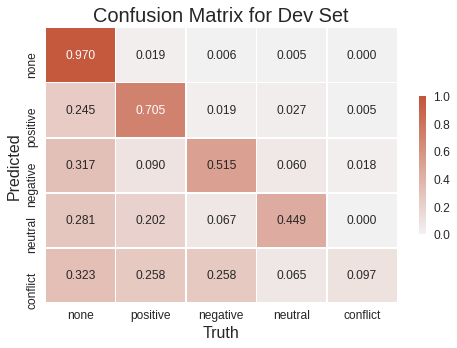

In [14]:
def draw_confusion_matrix(confusion):
            
    sns.set_theme(style="white")
    plt.style.use("seaborn")
    plt.rcParams.update({
        "figure.titlesize": 26,
        "axes.titlesize": 20,
        "axes.labelsize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.title_fontsize": 16,
        "legend.fontsize": 12
    })

    labels = ["none", "positive", "negative", "neutral", "conflict"]

    fig, ax = plt.subplots(figsize=(7, 5))
    cmap = sns.diverging_palette(230, 20, as_cmap = True)

    X = confusion / confusion.sum(1, keepdims = True)

    sns.heatmap(
        pd.DataFrame(X, index=labels, columns = labels), 
        cmap = cmap, 
        center = 0,
        vmin = 0,
        vmax = 1,
        annot = True, 
        fmt = ".3f",
        linewidths = .5, 
        cbar_kws = {
            "shrink": .5
        }
    )
    ax.set_title("Confusion Matrix for Dev Set")
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")
    plt.tight_layout()
    plt.show()


confusion = draw_confusion_matrix(model.get_confusion())   

In [15]:
def CategoryExtractionSentimentPredict(model, device, dataset, hparams):

    tokenizer = AutoTokenizer.from_pretrained(hparams.model_name)

    sentiment_types = ["none", "positive", "negative", "neutral", "conflict"]
    categories = ["anecdotes/miscellaneous", "price", "food", "ambience", "service"]
    num_categories = 5

    predictions = []
    test_predictions = []
    
    for sample in dataset:

        if "categories" not in sample:
          predictions.append([])
          test_predictions.append([])
          continue

        sentence = sample["text"]

        tokenized = tokenizer(num_categories * [sentence], categories, padding = True, truncation = True, max_length = 512, return_tensors = "pt")

        with torch.no_grad():

            input_ids = tokenized["input_ids"].to(device)
            attention_mask = tokenized["attention_mask"].to(device)

            output = model(input_ids = input_ids, attention_mask = attention_mask)

            logits = output["logits"]

            pred = torch.softmax(logits, -1).argmax(-1)
            y_pred = pred.cpu()

            predicted_list = []
            true_list = []
            

            print("Predicted not cleaned")
            print([(category, sentiment_types[pred]) for (category, pred) in zip(categories, y_pred)])

            predicted_list = [(category, sentiment_types[pred]) for (category, pred) in zip(categories, y_pred) if pred > 0]


            true_list = [(category, sentiment) for (category, sentiment) in sample["categories"]]

            print("Predicted cleaned")
            print(predicted_list)
            print("Ground truth")
            print(true_list)
            print("*"*30)
        

            predictions.append(predicted_list)
            test_predictions.append(true_list)
    
    
    #return zip(predictions, test_predictions)
    return predictions

In [17]:
def evaluate_sentiment(samples, predictions_b, mode="Category Sentiment"):
    scores = {}
    sentiment_types = ["positive", "negative", "neutral", "conflict"]
    scores = {sent: {"tp": 0, "fp": 0, "fn": 0} for sent in sentiment_types + ["ALL"]}
    for label, pred in zip(samples, predictions_b):
        for sentiment in sentiment_types:
            if "categories" in label:
                pred_sent = {(term_pred[0], term_pred[1]) for term_pred in pred if
                                term_pred[1] == sentiment}
                gt_sent = {(term_pred[0], term_pred[1]) for term_pred in label["categories"] if
                                term_pred[1] == sentiment}
            else:
                continue

            scores[sentiment]["tp"] += len(pred_sent & gt_sent)
            scores[sentiment]["fp"] += len(pred_sent - gt_sent)
            scores[sentiment]["fn"] += len(gt_sent - pred_sent)

    # Compute per sentiment Precision / Recall / F1
    for sent_type in scores.keys():
        if scores[sent_type]["tp"]:
            scores[sent_type]["p"] = 100 * scores[sent_type]["tp"] / (scores[sent_type]["fp"] + scores[sent_type]["tp"])
            scores[sent_type]["r"] = 100 * scores[sent_type]["tp"] / (scores[sent_type]["fn"] + scores[sent_type]["tp"])
        else:
            scores[sent_type]["p"], scores[sent_type]["r"] = 0, 0

        if not scores[sent_type]["p"] + scores[sent_type]["r"] == 0:
            scores[sent_type]["f1"] = 2 * scores[sent_type]["p"] * scores[sent_type]["r"] / (
                    scores[sent_type]["p"] + scores[sent_type]["r"])
        else:
            scores[sent_type]["f1"] = 0

    # Compute micro F1 Scores
    tp = sum([scores[sent_type]["tp"] for sent_type in sentiment_types])
    fp = sum([scores[sent_type]["fp"] for sent_type in sentiment_types])
    fn = sum([scores[sent_type]["fn"] for sent_type in sentiment_types])

    if tp:
        precision = 100 * tp / (tp + fp)
        recall = 100 * tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)

    else:
        precision, recall, f1 = 0, 0, 0

    scores["ALL"]["p"] = precision
    scores["ALL"]["r"] = recall
    scores["ALL"]["f1"] = f1
    scores["ALL"]["tp"] = tp
    scores["ALL"]["fp"] = fp
    scores["ALL"]["fn"] = fn

    # Compute Macro F1 Scores
    scores["ALL"]["Macro_f1"] = sum([scores[ent_type]["f1"] for ent_type in sentiment_types])/len(sentiment_types)
    scores["ALL"]["Macro_p"] = sum([scores[ent_type]["p"] for ent_type in sentiment_types])/len(sentiment_types)
    scores["ALL"]["Macro_r"] = sum([scores[ent_type]["r"] for ent_type in sentiment_types])/len(sentiment_types)

    print(f"{mode} Evaluation\n")

    print(
        "\tALL\t TP: {};\tFP: {};\tFN: {}".format(
            scores["ALL"]["tp"],
            scores["ALL"]["fp"],
            scores["ALL"]["fn"]))
    print(
        "\t\t(m avg): precision: {:.2f};\trecall: {:.2f};\tf1: {:.2f} (micro)".format(
            precision,
            recall,
            f1))
    print(
        "\t\t(M avg): precision: {:.2f};\trecall: {:.2f};\tf1: {:.2f} (Macro)\n".format(
            scores["ALL"]["Macro_p"],
            scores["ALL"]["Macro_r"],
            scores["ALL"]["Macro_f1"]))

    for sent_type in sentiment_types:
        print("\t{}: \tTP: {};\tFP: {};\tFN: {};\tprecision: {:.2f};\trecall: {:.2f};\tf1: {:.2f};\t{}".format(
            sent_type,
            scores[sent_type]["tp"],
            scores[sent_type]["fp"],
            scores[sent_type]["fn"],
            scores[sent_type]["p"],
            scores[sent_type]["r"],
            scores[sent_type]["f1"],
            scores[sent_type]["tp"] +
            scores[sent_type][
                "fp"]))

    return scores, precision, recall, f1

evaluate_sentiment(dev_samples, CategoryExtractionSentimentPredict(model.model, device, dev_samples, hparams))

Predicted not cleaned
[('anecdotes/miscellaneous', 'positive'), ('price', 'none'), ('food', 'none'), ('ambience', 'none'), ('service', 'none')]
Predicted cleaned
[('anecdotes/miscellaneous', 'positive')]
Ground truth
[('anecdotes/miscellaneous', 'positive')]
******************************
Predicted not cleaned
[('anecdotes/miscellaneous', 'none'), ('price', 'none'), ('food', 'negative'), ('ambience', 'none'), ('service', 'none')]
Predicted cleaned
[('food', 'negative')]
Ground truth
[('food', 'negative')]
******************************
Predicted not cleaned
[('anecdotes/miscellaneous', 'none'), ('price', 'none'), ('food', 'none'), ('ambience', 'none'), ('service', 'negative')]
Predicted cleaned
[('service', 'negative')]
Ground truth
[('service', 'conflict')]
******************************
Predicted not cleaned
[('anecdotes/miscellaneous', 'none'), ('price', 'none'), ('food', 'none'), ('ambience', 'none'), ('service', 'none')]
Predicted cleaned
[]
Ground truth
[('anecdotes/miscellaneous

({'ALL': {'Macro_f1': 49.577189033489844,
   'Macro_p': 60.24901773388553,
   'Macro_r': 44.149242242959275,
   'f1': 65.2317880794702,
   'fn': 269,
   'fp': 151,
   'p': 72.29357798165138,
   'r': 59.42684766214178,
   'tp': 394},
  'conflict': {'f1': 15.384615384615385,
   'fn': 28,
   'fp': 5,
   'p': 37.5,
   'r': 9.67741935483871,
   'tp': 3},
  'negative': {'f1': 59.93031358885017,
   'fn': 81,
   'fp': 34,
   'p': 71.66666666666667,
   'r': 51.49700598802395,
   'tp': 86},
  'neutral': {'f1': 49.382716049382715,
   'fn': 49,
   'fp': 33,
   'p': 54.794520547945204,
   'r': 44.943820224719104,
   'tp': 40},
  'positive': {'f1': 73.61111111111111,
   'fn': 111,
   'fp': 79,
   'p': 77.03488372093024,
   'r': 70.47872340425532,
   'tp': 265}},
 72.29357798165138,
 59.42684766214178,
 65.2317880794702)

#**Evaluate c**#

In [18]:
def predict_c(model, device, dataset, hparams):

    tokenizer = AutoTokenizer.from_pretrained(hparams.model_name)
    categories = ["anecdotes/miscellaneous", "price", "food", "ambience", "service"]
    num_categories = 5
    predictions = []
    test_predictions = []
    for sample in dataset:
    
        sentence = sample["text"]

        tokenized = tokenizer(num_categories * [sentence], categories, padding = True, truncation = True, max_length = 512, return_tensors = "pt")

        with torch.no_grad():

            input_ids = tokenized["input_ids"].to(device)
            attention_mask = tokenized["attention_mask"].to(device)

            output = model(input_ids = input_ids, attention_mask = attention_mask)

            logits = output["logits"]

            pred = torch.softmax(logits, -1).argmax(-1)
            y_pred = pred.cpu()

            predicted_list = []
            true_list = []
            

            predicted_list = [category for (category, pred) in zip(categories,y_pred) if pred > 0]
            true_list = [category[0] for category in sample["categories"]]
        

            predictions.append(predicted_list)
            test_predictions.append(true_list)
    
    
    #return zip(predictions, test_predictions)
    return predictions

In [20]:
def evaluate_sentiment_c(samples, predictions_b, mode="Aspect Sentiment"):

    scores = {}
    sentiment_types = ["anecdotes/miscellaneous", "price", "food", "ambience", "service"]
  
    scores = {sent: {"tp": 0, "fp": 0, "fn": 0} for sent in sentiment_types + ["ALL"]}

    for label, pred in zip(samples, predictions_b):
        for sentiment in sentiment_types:
            if "categories" in label:
                pred_sent = {(term_pred) for term_pred in pred if
                                term_pred == sentiment}
                gt_sent = {(term_pred[0]) for term_pred in label["categories"] if
                                term_pred[0] == sentiment}
            else:
                continue

            print("Prediction")
            print(pred_sent)
            print("Groung truth")
            print(gt_sent)
            print("-"*30)

            scores[sentiment]["tp"] += len(pred_sent & gt_sent)
            scores[sentiment]["fp"] += len(pred_sent - gt_sent)
            scores[sentiment]["fn"] += len(gt_sent - pred_sent)

    # Compute per sentiment Precision / Recall / F1
    for sent_type in scores.keys():
        if scores[sent_type]["tp"]:
            scores[sent_type]["p"] = 100 * scores[sent_type]["tp"] / (scores[sent_type]["fp"] + scores[sent_type]["tp"])
            scores[sent_type]["r"] = 100 * scores[sent_type]["tp"] / (scores[sent_type]["fn"] + scores[sent_type]["tp"])
        else:
            scores[sent_type]["p"], scores[sent_type]["r"] = 0, 0

        if not scores[sent_type]["p"] + scores[sent_type]["r"] == 0:
            scores[sent_type]["f1"] = 2 * scores[sent_type]["p"] * scores[sent_type]["r"] / (
                    scores[sent_type]["p"] + scores[sent_type]["r"])
        else:
            scores[sent_type]["f1"] = 0

    # Compute micro F1 Scores
    tp = sum([scores[sent_type]["tp"] for sent_type in sentiment_types])
    fp = sum([scores[sent_type]["fp"] for sent_type in sentiment_types])
    fn = sum([scores[sent_type]["fn"] for sent_type in sentiment_types])

    if tp:
        precision = 100 * tp / (tp + fp)
        recall = 100 * tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)

    else:
        precision, recall, f1 = 0, 0, 0

    scores["ALL"]["p"] = precision
    scores["ALL"]["r"] = recall
    scores["ALL"]["f1"] = f1
    scores["ALL"]["tp"] = tp
    scores["ALL"]["fp"] = fp
    scores["ALL"]["fn"] = fn

    # Compute Macro F1 Scores
    scores["ALL"]["Macro_f1"] = sum([scores[ent_type]["f1"] for ent_type in sentiment_types])/len(sentiment_types)
    scores["ALL"]["Macro_p"] = sum([scores[ent_type]["p"] for ent_type in sentiment_types])/len(sentiment_types)
    scores["ALL"]["Macro_r"] = sum([scores[ent_type]["r"] for ent_type in sentiment_types])/len(sentiment_types)

    print(f"{mode} Evaluation\n")

    print(
        "\tALL\t TP: {};\tFP: {};\tFN: {}".format(
            scores["ALL"]["tp"],
            scores["ALL"]["fp"],
            scores["ALL"]["fn"]))
    print(
        "\t\t(m avg): precision: {:.2f};\trecall: {:.2f};\tf1: {:.2f} (micro)".format(
            precision,
            recall,
            f1))
    print(
        "\t\t(M avg): precision: {:.2f};\trecall: {:.2f};\tf1: {:.2f} (Macro)\n".format(
            scores["ALL"]["Macro_p"],
            scores["ALL"]["Macro_r"],
            scores["ALL"]["Macro_f1"]))

    for sent_type in sentiment_types:
        print("\t{}: \tTP: {};\tFP: {};\tFN: {};\tprecision: {:.2f};\trecall: {:.2f};\tf1: {:.2f};\t{}".format(
            sent_type,
            scores[sent_type]["tp"],
            scores[sent_type]["fp"],
            scores[sent_type]["fn"],
            scores[sent_type]["p"],
            scores[sent_type]["r"],
            scores[sent_type]["f1"],
            scores[sent_type]["tp"] +
            scores[sent_type][
                "fp"]))

    return scores, precision, recall, f1

evaluate_sentiment_c(dev_samples, predict_c(model.model, device, dev_samples, hparams))

Выходные данные были обрезаны до нескольких последних строк (5000).
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
{'price'}
Groung truth
{'price'}
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
{'ambience'}
Groung truth
{'ambience'}
------------------------------
Prediction
set()
Groung truth
set()
------------------------------
Prediction
{'anecdotes/miscellaneous'}
Groung trut

({'ALL': {'Macro_f1': 77.52513820698663,
   'Macro_p': 89.80682949747045,
   'Macro_r': 69.29272936577574,
   'f1': 79.96688741721854,
   'fn': 180,
   'fp': 62,
   'p': 88.62385321100918,
   'r': 72.85067873303167,
   'tp': 483},
  'ambience': {'f1': 65.51724137931035,
   'fn': 38,
   'fp': 2,
   'p': 95.0,
   'r': 50.0,
   'tp': 38},
  'anecdotes/miscellaneous': {'f1': 76.83284457478007,
   'fn': 60,
   'fp': 19,
   'p': 87.33333333333333,
   'r': 68.58638743455498,
   'tp': 131},
  'food': {'f1': 85.19362186788156,
   'fn': 37,
   'fp': 28,
   'p': 86.97674418604652,
   'r': 83.48214285714286,
   'tp': 187},
  'price': {'f1': 76.59574468085107,
   'fn': 17,
   'fp': 5,
   'p': 87.8048780487805,
   'r': 67.9245283018868,
   'tp': 36},
  'service': {'f1': 83.48623853211008,
   'fn': 28,
   'fp': 8,
   'p': 91.91919191919192,
   'r': 76.47058823529412,
   'tp': 91}},
 88.62385321100918,
 72.85067873303167,
 79.96688741721854)

#**Evaluate d**#

In [21]:
def predict_d(model, device, dataset, hparams):

    tokenizer = AutoTokenizer.from_pretrained(hparams.model_name)

    sentiment_types = ["none", "positive", "negative", "neutral", "conflict"]

    predictions = []
    test_predictions = []
    for sample in dataset:

        if "categories" not in sample:
          predictions.append([])
          test_predictions.append([])
          continue

        sentence = sample["text"]
        categories = [category[0] for category in sample["categories"]]
        num_categories = len(categories)

        tokenized = tokenizer(num_categories * [sentence], categories, padding = True, truncation = True, max_length = 512, return_tensors = "pt")

        with torch.no_grad():

            input_ids = tokenized["input_ids"].to(device)
            attention_mask = tokenized["attention_mask"].to(device)

            output = model(input_ids = input_ids, attention_mask = attention_mask)

            logits = output["logits"]

            pred = torch.softmax(logits, -1).argmax(-1)
            y_pred = pred.cpu()

            predicted_list = []
            true_list = []
            

            predicted_list = [(category, sentiment_types[pred]) for (category, pred) in zip(categories, y_pred)]


            true_list = [(category, sentiment) for (category, sentiment) in sample["categories"]]
        

            predictions.append(predicted_list)
            test_predictions.append(true_list)
    
    
    #return zip(predictions, test_predictions)
    return predictions

In [23]:
def evaluate_sentiment_d(samples, predictions_b, mode="Aspect Sentiment"):
    scores = {}

    sentiment_types = ["positive", "negative", "neutral", "conflict"]
    scores = {sent: {"tp": 0, "fp": 0, "fn": 0} for sent in sentiment_types + ["ALL"]}
    for label, pred in zip(samples, predictions_b):
        for sentiment in sentiment_types:
            if "categories" in label:
                pred_sent = {(term_pred[0], term_pred[1]) for term_pred in pred if
                                term_pred[1] == sentiment}
                gt_sent = {(term_pred[0], term_pred[1]) for term_pred in label["categories"] if
                                term_pred[1] == sentiment}
            else:
                continue

            scores[sentiment]["tp"] += len(pred_sent & gt_sent)
            scores[sentiment]["fp"] += len(pred_sent - gt_sent)
            scores[sentiment]["fn"] += len(gt_sent - pred_sent)

    # Compute per sentiment Precision / Recall / F1
    for sent_type in scores.keys():
        if scores[sent_type]["tp"]:
            scores[sent_type]["p"] = 100 * scores[sent_type]["tp"] / (scores[sent_type]["fp"] + scores[sent_type]["tp"])
            scores[sent_type]["r"] = 100 * scores[sent_type]["tp"] / (scores[sent_type]["fn"] + scores[sent_type]["tp"])
        else:
            scores[sent_type]["p"], scores[sent_type]["r"] = 0, 0

        if not scores[sent_type]["p"] + scores[sent_type]["r"] == 0:
            scores[sent_type]["f1"] = 2 * scores[sent_type]["p"] * scores[sent_type]["r"] / (
                    scores[sent_type]["p"] + scores[sent_type]["r"])
        else:
            scores[sent_type]["f1"] = 0

    # Compute micro F1 Scores
    tp = sum([scores[sent_type]["tp"] for sent_type in sentiment_types])
    fp = sum([scores[sent_type]["fp"] for sent_type in sentiment_types])
    fn = sum([scores[sent_type]["fn"] for sent_type in sentiment_types])

    if tp:
        precision = 100 * tp / (tp + fp)
        recall = 100 * tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)

    else:
        precision, recall, f1 = 0, 0, 0

    scores["ALL"]["p"] = precision
    scores["ALL"]["r"] = recall
    scores["ALL"]["f1"] = f1
    scores["ALL"]["tp"] = tp
    scores["ALL"]["fp"] = fp
    scores["ALL"]["fn"] = fn

    # Compute Macro F1 Scores
    scores["ALL"]["Macro_f1"] = sum([scores[ent_type]["f1"] for ent_type in sentiment_types])/len(sentiment_types)
    scores["ALL"]["Macro_p"] = sum([scores[ent_type]["p"] for ent_type in sentiment_types])/len(sentiment_types)
    scores["ALL"]["Macro_r"] = sum([scores[ent_type]["r"] for ent_type in sentiment_types])/len(sentiment_types)

    print(f"{mode} Evaluation\n")

    print(
        "\tALL\t TP: {};\tFP: {};\tFN: {}".format(
            scores["ALL"]["tp"],
            scores["ALL"]["fp"],
            scores["ALL"]["fn"]))
    print(
        "\t\t(m avg): precision: {:.2f};\trecall: {:.2f};\tf1: {:.2f} (micro)".format(
            precision,
            recall,
            f1))
    print(
        "\t\t(M avg): precision: {:.2f};\trecall: {:.2f};\tf1: {:.2f} (Macro)\n".format(
            scores["ALL"]["Macro_p"],
            scores["ALL"]["Macro_r"],
            scores["ALL"]["Macro_f1"]))

    for sent_type in sentiment_types:
        print("\t{}: \tTP: {};\tFP: {};\tFN: {};\tprecision: {:.2f};\trecall: {:.2f};\tf1: {:.2f};\t{}".format(
            sent_type,
            scores[sent_type]["tp"],
            scores[sent_type]["fp"],
            scores[sent_type]["fn"],
            scores[sent_type]["p"],
            scores[sent_type]["r"],
            scores[sent_type]["f1"],
            scores[sent_type]["tp"] +
            scores[sent_type][
                "fp"]))

    return scores, precision, recall, f1

evaluate_sentiment_d(dev_samples, predict_d(model.model, device, dev_samples, hparams))

Aspect Sentiment Evaluation

	ALL	 TP: 394;	FP: 89;	FN: 269
		(m avg): precision: 81.57;	recall: 59.43;	f1: 68.76 (micro)
		(M avg): precision: 67.25;	recall: 44.15;	f1: 52.21 (Macro)

	positive: 	TP: 265;	FP: 41;	FN: 111;	precision: 86.60;	recall: 70.48;	f1: 77.71;	306
	negative: 	TP: 86;	FP: 21;	FN: 81;	precision: 80.37;	recall: 51.50;	f1: 62.77;	107
	neutral: 	TP: 40;	FP: 22;	FN: 49;	precision: 64.52;	recall: 44.94;	f1: 52.98;	62
	conflict: 	TP: 3;	FP: 5;	FN: 28;	precision: 37.50;	recall: 9.68;	f1: 15.38;	8


({'ALL': {'Macro_f1': 52.212770108339555,
   'Macro_p': 67.24781699937537,
   'Macro_r': 44.149242242959275,
   'f1': 68.760907504363,
   'fn': 269,
   'fp': 89,
   'p': 81.5734989648033,
   'r': 59.42684766214178,
   'tp': 394},
  'conflict': {'f1': 15.384615384615385,
   'fn': 28,
   'fp': 5,
   'p': 37.5,
   'r': 9.67741935483871,
   'tp': 3},
  'negative': {'f1': 62.77372262773722,
   'fn': 81,
   'fp': 21,
   'p': 80.37383177570094,
   'r': 51.49700598802395,
   'tp': 86},
  'neutral': {'f1': 52.980132450331126,
   'fn': 49,
   'fp': 22,
   'p': 64.51612903225806,
   'r': 44.943820224719104,
   'tp': 40},
  'positive': {'f1': 77.71260997067449,
   'fn': 111,
   'fp': 41,
   'p': 86.60130718954248,
   'r': 70.47872340425532,
   'tp': 265}},
 81.5734989648033,
 59.42684766214178,
 68.760907504363)